<a href="https://colab.research.google.com/github/ichisadashioko/dqn/blob/master/dqn_cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow==2.0.0-beta1

In [0]:
!pip install tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 39kB/s 


In [0]:
import os
import time
import math
import random
from datetime import datetime
from collections import namedtuple

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import gym
from gym.envs.registration import register

In [0]:
# disable TensorFlow logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.optimizers import RMSprop

In [0]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity=1_000_000):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size=32):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [0]:
memory = ReplayMemory()
len(memory)

0

In [0]:
env_name = 'CartPole-v0'
env = gym.make(env_name)

## Hyperparameters

In [0]:
from google.colab import drive

In [0]:
mount_point = '/gdrive'
drive.mount(mount_point, force_remount=True)

Mounted at /gdrive


In [0]:
save_dir = f'{mount_point}/My Drive/DQN-{env_name}'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

os.path.exists(save_dir)

True

In [0]:
input_shape = env.observation_space.shape
n_actions = env.action_space.n
lr = 0.0001
BATCH_SIZE = 32
GAMMA = 0.99

EPS_START = 1 # initial value of epsilon
EPS_END = 0.1 # final value of epsilon
EPS_DECAY = 500_000 # number of steps until epsilon reach its final value
steps_done = 0

In [0]:
def create_network(name, input_shape, n_actions, lr, activation_name):
    model = keras.Sequential(name=name, layers=[
        Dense(
            name=f'{name}_dense_01',
            units=32,
            input_shape=input_shape,
            activation=activation_name,
        ),
        Dense(
            name=f'{name}_dense_02',
            units=64,
            activation=activation_name,
        ),
        Dense(
            name=f'{name}_dense_03',
            units=n_actions,
            activation='linear',
        )
    ])

    optimizer = RMSprop(lr=lr)

    model.compile(
        optimizer=optimizer,
        loss='mse',
    )

    return model

In [0]:
activation_name = 'relu'

target_net = create_network(
    name='target_net',
    input_shape=input_shape,
    n_actions=n_actions,
    lr=lr,
    activation_name=activation_name,
)

target_net.summary()

policy_net = create_network(
    name='policy_net',
    input_shape=input_shape,
    n_actions=n_actions,
    lr=lr,
    activation_name=activation_name,
)

policy_net.summary()

Model: "target_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
target_net_dense_01 (Dense)  (None, 32)                160       
_________________________________________________________________
target_net_dense_02 (Dense)  (None, 64)                2112      
_________________________________________________________________
target_net_dense_03 (Dense)  (None, 2)                 130       
Total params: 2,402
Trainable params: 2,402
Non-trainable params: 0
_________________________________________________________________
Model: "policy_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
policy_net_dense_01 (Dense)  (None, 32)                160       
_________________________________________________________________
policy_net_dense_02 (Dense)  (None, 64)                2112      
__________________________________

In [0]:
target_net.weights[0]

<tf.Variable 'target_net_dense_01/kernel:0' shape=(4, 32) dtype=float32, numpy=
array([[-0.2903304 ,  0.15775728, -0.3099111 , -0.13895291, -0.37072566,
        -0.23374824,  0.14921874,  0.34970367,  0.17436069, -0.23189111,
        -0.27255774,  0.24855256,  0.01648107, -0.14891806,  0.09979576,
        -0.1533674 ,  0.20650727,  0.25669026, -0.05707413, -0.39687356,
         0.27697426,  0.39898843, -0.3062862 ,  0.2389713 , -0.02829149,
        -0.38638067, -0.03242448, -0.23036072,  0.13910133, -0.3045591 ,
        -0.32903868,  0.2776913 ],
       [-0.3850325 , -0.19779979, -0.10743013, -0.19120093, -0.3331997 ,
        -0.37097153, -0.12807515, -0.21097355, -0.32262614,  0.14916062,
        -0.29991987,  0.371311  ,  0.06295699, -0.39255184, -0.36007148,
        -0.01850864, -0.33189934,  0.35801655, -0.08989152,  0.03506088,
        -0.14240673, -0.39952406,  0.31688052, -0.36672115, -0.050255  ,
        -0.09038717, -0.3145625 ,  0.05345768,  0.2746902 ,  0.01589465,
        -

In [0]:
policy_net.weights[0]

<tf.Variable 'policy_net_dense_01/kernel:0' shape=(4, 32) dtype=float32, numpy=
array([[-0.20500746, -0.19056922, -0.05996153, -0.36269826,  0.1903401 ,
        -0.04625234,  0.13225448, -0.03558987,  0.3774014 ,  0.27509642,
        -0.10304087,  0.29859477,  0.1840874 , -0.4077328 ,  0.3075052 ,
        -0.03155178, -0.11757031, -0.35948884, -0.02733284,  0.28894544,
         0.34326434,  0.16701752,  0.26890773,  0.35464144, -0.38859773,
         0.3573107 ,  0.26546663,  0.06170556, -0.30949217, -0.1771384 ,
         0.15233165,  0.09460551],
       [ 0.18717033,  0.05433017, -0.3691437 , -0.02557811, -0.2737561 ,
        -0.07500079, -0.08398044,  0.16096956,  0.05259228, -0.21786226,
         0.39554846, -0.39706793, -0.23934563,  0.14055687, -0.2239903 ,
         0.26672244,  0.10834128,  0.07291472, -0.2393577 , -0.30546916,
        -0.1414693 ,  0.03931484,  0.00361314,  0.02392364, -0.03025296,
        -0.23572539,  0.22830749, -0.20870109, -0.07915083, -0.26178187,
         

In [0]:
def target_to_policy():
    for i in range(len(policy_net.weights)):
        tf.keras.backend.set_value(policy_net.weights[i], target_net.weights[i].numpy())

def policy_to_target():
    for i in range(len(target_net.weights)):
        tf.keras.backend.set_value(target_net.weights[i], policy_net.weights[i].numpy())

Copy weights from target network to policy network

In [0]:
target_to_policy()

In [0]:
target_net.weights[0]

<tf.Variable 'target_net_dense_01/kernel:0' shape=(4, 32) dtype=float32, numpy=
array([[-0.2903304 ,  0.15775728, -0.3099111 , -0.13895291, -0.37072566,
        -0.23374824,  0.14921874,  0.34970367,  0.17436069, -0.23189111,
        -0.27255774,  0.24855256,  0.01648107, -0.14891806,  0.09979576,
        -0.1533674 ,  0.20650727,  0.25669026, -0.05707413, -0.39687356,
         0.27697426,  0.39898843, -0.3062862 ,  0.2389713 , -0.02829149,
        -0.38638067, -0.03242448, -0.23036072,  0.13910133, -0.3045591 ,
        -0.32903868,  0.2776913 ],
       [-0.3850325 , -0.19779979, -0.10743013, -0.19120093, -0.3331997 ,
        -0.37097153, -0.12807515, -0.21097355, -0.32262614,  0.14916062,
        -0.29991987,  0.371311  ,  0.06295699, -0.39255184, -0.36007148,
        -0.01850864, -0.33189934,  0.35801655, -0.08989152,  0.03506088,
        -0.14240673, -0.39952406,  0.31688052, -0.36672115, -0.050255  ,
        -0.09038717, -0.3145625 ,  0.05345768,  0.2746902 ,  0.01589465,
        -

In [0]:
policy_net.weights[0]

<tf.Variable 'policy_net_dense_01/kernel:0' shape=(4, 32) dtype=float32, numpy=
array([[-0.2903304 ,  0.15775728, -0.3099111 , -0.13895291, -0.37072566,
        -0.23374824,  0.14921874,  0.34970367,  0.17436069, -0.23189111,
        -0.27255774,  0.24855256,  0.01648107, -0.14891806,  0.09979576,
        -0.1533674 ,  0.20650727,  0.25669026, -0.05707413, -0.39687356,
         0.27697426,  0.39898843, -0.3062862 ,  0.2389713 , -0.02829149,
        -0.38638067, -0.03242448, -0.23036072,  0.13910133, -0.3045591 ,
        -0.32903868,  0.2776913 ],
       [-0.3850325 , -0.19779979, -0.10743013, -0.19120093, -0.3331997 ,
        -0.37097153, -0.12807515, -0.21097355, -0.32262614,  0.14916062,
        -0.29991987,  0.371311  ,  0.06295699, -0.39255184, -0.36007148,
        -0.01850864, -0.33189934,  0.35801655, -0.08989152,  0.03506088,
        -0.14240673, -0.39952406,  0.31688052, -0.36672115, -0.050255  ,
        -0.09038717, -0.3145625 ,  0.05345768,  0.2746902 ,  0.01589465,
        -

In [0]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    if sample > eps_threshold:
        batch = np.array([state])
        action = np.argmax(policy_net.predict(batch)[0])
    else:
        action = random.randrange(n_actions)
    
    steps_done += 1
    return action

In [0]:
EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)

1.0

In [0]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    
    transitions = memory.sample(BATCH_SIZE)
    # transpose the batch
    batch = Transition(*zip(*transitions))
    
    s = np.array(batch.state)
    a = np.array(batch.action)
    r = np.array(batch.reward)
    
    non_final_mask = np.array(list(map(lambda s: s is not None, batch.next_state)))
    non_final_s2 = np.array([s for s in batch.next_state if s is not None])
    
    # compute V(s_{t+1}) for all next states (except for terminal states)
    s2_values = target_net.predict(non_final_s2)
    target_q = np.zeros((BATCH_SIZE, n_actions), dtype=np.float32)
    s2_index = 0
    for i in range(BATCH_SIZE):
        if non_final_mask[i]:
            target_q[i][a[i]] = np.max(s2_values[s2_index]) * GAMMA + r[i]
            s2_index += 1
    
    policy_net.fit(
        x=s,
        y=target_q,
        verbose=0,
    )

## Training loop

In [0]:
train_reward_log = []

100%|██████████| 500000/500000 [44:40<00:00, 186.50it/s]



Mean: 60.58
Max: 200.0
Min: 8.0


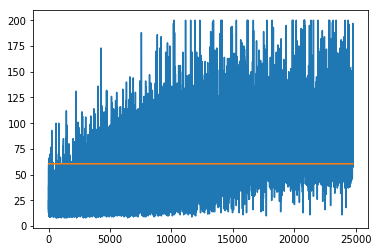

In [34]:
update_freq = 10_000
save_freq = 20_000

num_steps = 500_000

state = env.reset()
ep_reward = 0

for step_num in tqdm(range(num_steps)):
    action = select_action(state) # select action use epsilon-greedy
    # the agent is seem to perform better when training with random data (the first 500_000 steps only)
    # action = random.randrange(n_actions)
    next_state, reward, done, info = env.step(action)
    ep_reward += reward
    
    if done:
        next_state = None
    memory.push(state, action, next_state, reward)
    
    if done:
        state = env.reset()
        train_reward_log.append(ep_reward)
        ep_reward = 0
    else:
        state = next_state
    
    optimize_model()
    
    if step_num > 0:
        if step_num % update_freq == 0:
            policy_to_target()
        if step_num % save_freq == 0:
            timestr = time.strftime('%Y%m%d-%H%M%S')
            fname = f'{save_dir}/weights_{timestr}_{activation_name}_{steps_done}.h5'
            target_net.save_weights(fname)

timestr = time.strftime('%Y%m%d-%H%M%S')
fname = f'{save_dir}/model_{timestr}_{activation_name}_{steps_done}.h5'
target_net.save(fname)

np_reward = np.array(train_reward_log[-num_steps:])

reward_mean = np.mean(np_reward)
reward_max = np.max(np_reward)
reward_min = np.min(np_reward)

print()
print(f'Mean: {reward_mean:.2f}')
print(f'Max: {reward_max}')
print(f'Min: {reward_min}')

mean_plot = np.zeros_like(np_reward)
mean_plot.fill(reward_mean)

plt.plot(np_reward)
plt.plot(mean_plot)

Populate memory for testing if you haven't start training loop.

In [0]:
state = env.reset()
reward = 0

for _ in tqdm(range(100_000)):
    action = random.randrange(n_actions)
    next_state, reward, done, info = env.step(action)
    
    if done:
        next_state = None
    memory.push(state, action, next_state, reward)
    
    if done:
        state = env.reset()
    else:
        state = next_state

100%|██████████| 100000/100000 [00:01<00:00, 69637.43it/s]


## Evaluate target network

Use random as baseline

100%|██████████| 100/100 [00:00<00:00, 2885.26it/s]


Mean: 23.31
Max: 63.0
Min: 10.0


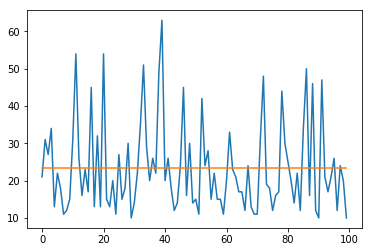

In [37]:
num_episodes = 100
max_steps = 2_000

reward_log = []
action_log = []

for episode in tqdm(range(num_episodes)):

    state = env.reset()

    total_reward = 0
    ep_action_log = []

    for _ in range(max_steps):
        action = random.randrange(env.action_space.n)
        ep_action_log.append(action)
        next_state, reward, done, info = env.step(action)
        total_reward += reward

        state = next_state

        if done:
            break
    
    reward_log.append(total_reward)
    action_log.append(ep_action_log)

reward_log = np.array(reward_log)

reward_mean = np.mean(reward_log)
reward_max = np.max(reward_log)
reward_min = np.min(reward_log)

print()
print(f'Mean: {reward_mean}')
print(f'Max: {reward_max}')
print(f'Min: {reward_min}')

mean_plot = np.zeros_like(reward_log)
mean_plot.fill(reward_mean)

plt.plot(reward_log)
plt.plot(mean_plot)

## Now it's time for the agent's turn.

100%|██████████| 100/100 [00:10<00:00,  9.88it/s]


Mean: 85.01
Max: 197.0
Min: 46.0


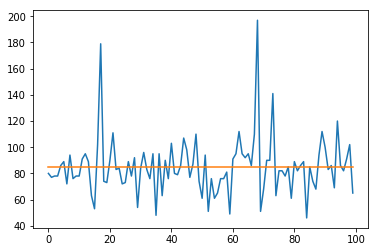

In [36]:
num_episodes = 100
max_steps = 2_000

reward_log = []
action_log = []

for episode in tqdm(range(num_episodes)):

    state = env.reset()

    total_reward = 0
    ep_action_log = []

    for _ in range(max_steps):
        action = np.argmax(target_net.predict(np.array([state]))[0])
        ep_action_log.append(action)
        next_state, reward, done, info = env.step(action)
        total_reward += reward

        state = next_state

        if done:
            break
    
    reward_log.append(total_reward)
    action_log.append(ep_action_log)
reward_log = np.array(reward_log)
reward_mean = np.mean(reward_log)
reward_max = np.max(reward_log)
reward_min = np.min(reward_log)

print()
print(f'Mean: {reward_mean}')
print(f'Max: {reward_max}')
print(f'Min: {reward_min}')

mean_plot = np.zeros_like(reward_log)
mean_plot.fill(reward_mean)

plt.plot(reward_log)
plt.plot(mean_plot)

In [0]:
len(action_log)

100

In [0]:
x = np.argmax(reward_log)
print(x)
print(reward_log[x])

2
200.0


In [0]:
target_net.save('CartPole-v0.h5')

## Evaluate using Q-value


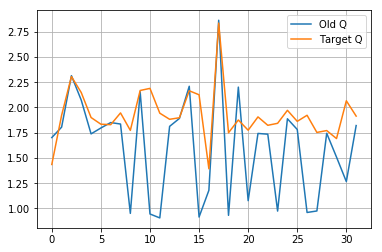

In [0]:
transitions = memory.sample(BATCH_SIZE)
# transpose the batch
batch = Transition(*zip(*transitions))

s = np.array(batch.state)
a = np.array(batch.action)
r = np.array(batch.reward)

non_final_mask = np.array(list(map(lambda s: s is not None, batch.next_state)))
non_final_s2 = np.array([s for s in batch.next_state if s is not None])

# compute V(s_{t+1}) for all next states (except for terminal states)
s2_values = target_net.predict(non_final_s2)
target_q = np.zeros((BATCH_SIZE, n_actions), dtype=np.float32)

# DEBUG
s_q = target_net.predict(s)
_old_q = []
_target_q = []
# END_DEBUG

s2_index = 0
for i in range(BATCH_SIZE):
    if non_final_mask[i]:
        target_q[i][a[i]] = np.max(s2_values[s2_index]) * GAMMA + r[i]
        # DEBUG
        _old_q.append(s_q[i][a[i]])
#         _target_q.append(target_q[i][a[i]])
        _target_q.append(np.max(s2_values[s2_index]))
        # END_DEBUG
        s2_index += 1
    else:
        # DEBUG
        _old_q.append(s_q[i][a[i]])
        _target_q.append(0)
        # END_DEBUG
_old_q = np.array(_old_q)
_target_q = np.array(_target_q)

plt.plot(_old_q, label='Old Q')
plt.plot(_target_q, label='Target Q')
plt.legend()
plt.grid()